<a href="https://colab.research.google.com/github/HarshithaGM01/customRLEnv/blob/main/CustomRLEnv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys, platform, random
import numpy as np

print("Python:", sys.version.split()[0])
print("Platform:", platform.platform())

SEED_271 = 271
random.seed(SEED_271)
np.random.seed(SEED_271)


Python: 3.12.12
Platform: Linux-6.6.105+-x86_64-with-glibc2.35


In [2]:
!pip -q install "gymnasium>=0.29" "stable-baselines3>=2.2.1" "shimmy>=1.3.0"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 4.4 MB/s eta 0:00:00


In [3]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np


In [4]:
class LongHorizonDecisionEnv(gym.Env):
    metadata = {"render_modes": []}
    def __init__(self, max_steps=200, seed=271, skill_bonus_weight=0.0):
      super().__init__()

      self.max_steps = max_steps
      self.current_step = 0
      self.skill_bonus_weight = float(skill_bonus_weight)
      self._rng = np.random.default_rng(seed)

      #observation space - we have [skill,energy,resources,confidence,market_noise]
      self.observation_space = spaces.Box(
          low=0.0,
          high=1.0,
          shape=(5,),
          dtype=np.float32
      )

      #Action space - 0: invest in a skill
      # 1: exploit current skill
      # 2: rest/recover
      # 3: take risky opportunity
      # 4: play safe
      self.action_space = spaces.Discrete(5)

      self.state = None

    def reset(self, seed=None, options=None):
      super().reset(seed=seed)

      if seed is not None:
        self._rng = np.random.default_rng(seed)

      self.current_step = 0

      skill = self._rng.uniform(0.1, 0.3)
      energy = self._rng.uniform(0.6, 0.9)
      resources = self._rng.uniform(0.4, 0.7)
      confidence = self._rng.uniform(0.3, 0.6)
      market_noise = self._rng.uniform(0.0, 1.0)

      self.state = np.array(
            [skill, energy, resources, confidence, market_noise],
            dtype=np.float32
        )

      return self.state, {}


    def step(self, action):

      skill, energy, resources, confidence, market_noise = self.state.astype(np.float32)

      # --- dynamics knobs (tunable later) ---
      invest_cost = 0.04
      exploit_cost_energy = 0.05
      exploit_gain_res = 0.06

      rest_gain_energy = 0.10
      rest_cost_res = 0.02

      safe_gain_res = 0.03
      safe_cost_energy = 0.01

      risky_cost_energy = 0.06
      risky_cost_res = 0.03
      risky_success_base = 0.20  # base success prob
      risky_success_skill_boost = 0.60  # extra prob from skill

      # Market noise updates each step (stochastic world)
      market_noise = float(self._rng.uniform(0.0, 1.0))

      # Track reward components for analysis
      immediate_reward = 0.0

      # --- apply action ---
      if action == 0:
        # invest in skill: slow payoff, upfront cost
        resources -= invest_cost
        energy -= 0.02
        skill += 0.03 + 0.01 * confidence
        confidence += 0.01
        immediate_reward -= 0.01  # tiny immediate penalty (delayed reward theme)

      elif action == 1:
        # exploit current skill: immediate gain but drains energy
        energy -= exploit_cost_energy
        gain = exploit_gain_res * (0.5 + skill) * (0.7 + 0.3 * market_noise)
        resources += gain
        confidence += 0.01
        immediate_reward += 0.5 * gain  # partial immediate reward

      elif action == 2:
        # rest: recovers energy, small cost to resources (time passes)
        energy += rest_gain_energy
        resources -= rest_cost_res
        confidence += 0.005
        immediate_reward -= 0.005

      elif action == 3:
        # risky opportunity: success depends on skill + randomness
        energy -= risky_cost_energy
        resources -= risky_cost_res

        p_success = risky_success_base + risky_success_skill_boost * skill
        p_success = float(np.clip(p_success, 0.0, 0.95))
        success = (self._rng.random() < p_success)

        if success:
          big_gain = 0.20 + 0.25 * market_noise + 0.10 * confidence
          resources += big_gain
          confidence += 0.04
          immediate_reward += big_gain
        else:
          confidence -= 0.03
          immediate_reward -= 0.03

      elif action == 4:
        # play safe: small reliable gain, minimal drain
        resources += safe_gain_res * (0.8 + 0.2 * market_noise)
        energy -= safe_cost_energy
        confidence += 0.002
        immediate_reward += 0.01

      else:
        raise ValueError(f"Invalid action: {action}")

      # --- natural dynamics / constraints ---
      # burnout effect: if energy too low, confidence and resources suffer
      if energy < 0.15:
        immediate_reward -= 0.05
        confidence -= 0.02
        resources -= 0.02

      # clamp to [0,1]
      skill = float(np.clip(skill, 0.0, 1.0))
      energy = float(np.clip(energy, 0.0, 1.0))
      resources = float(np.clip(resources, 0.0, 1.0))
      confidence = float(np.clip(confidence, 0.0, 1.0))

      self.state = np.array([skill, energy, resources, confidence, market_noise], dtype=np.float32)

      # --- delayed reward component ---
      # We want long-term stability + growth:
      # - reward increases with resources and skill
      # - penalty for low energy (burnout) and stagnation
      burnout_penalty = max(0.0, 0.25 - energy)  # only penalize when energy is low
      growth_reward = 0.6 * resources + 0.4 * skill
      reward = float(growth_reward - 0.8 * burnout_penalty + 0.2 * immediate_reward)
      reward = float(reward + self.skill_bonus_weight * skill)
      self.current_step += 1

      terminated = False
      truncated = False

      # terminate if resources depleted badly (collapse) or extreme burnout
      if resources <= 0.02 or energy <= 0.02:
        terminated = True

      # truncate if time horizon reached
      if self.current_step >= self.max_steps:
        truncated = True

      info = {
        "skill": skill,
        "energy": energy,
        "resources": resources,
        "confidence": confidence,
        "market_noise": market_noise,
        "burnout_penalty": burnout_penalty,
        "immediate_reward": immediate_reward,
        "growth_reward": growth_reward
      }

      return self.state, reward, terminated, truncated, info



In [5]:
# Create env + run a few random steps to sanity check
env_271 = LongHorizonDecisionEnv(max_steps=20, seed=271)

obs, info = env_271.reset()
print("Reset obs:", obs)

for t in range(5):
    a = env_271.action_space.sample()
    obs, reward, terminated, truncated, info = env_271.step(a)
    print(f"\nStep {t+1}")
    print("  action:", a)
    print("  obs:", obs)
    print("  reward:", reward)
    print("  terminated:", terminated, "| truncated:", truncated)
    print("  info (key fields):",
          {k: round(info[k], 3) for k in ["skill","energy","resources","confidence","burnout_penalty"]})
    if terminated or truncated:
        break


Reset obs: [0.2563959  0.8538769  0.5808103  0.3747876  0.19264777]

Step 1
  action: 1
  obs: [0.2563959 0.8038769 0.6195281 0.3847876 0.5104025]
  reward: 0.4781470000743866
  terminated: False | truncated: False
  info (key fields): {'skill': 0.256, 'energy': 0.804, 'resources': 0.62, 'confidence': 0.385, 'burnout_penalty': 0.0}

Step 2
  action: 2
  obs: [0.2563959  0.9038769  0.59952813 0.38978758 0.31200263]
  reward: 0.46127524280548093
  terminated: False | truncated: False
  info (key fields): {'skill': 0.256, 'energy': 0.904, 'resources': 0.6, 'confidence': 0.39, 'burnout_penalty': 0.0}

Step 3
  action: 4
  obs: [0.2563959  0.8938769  0.62519884 0.3917876  0.27845174]
  reward: 0.47967766714096066
  terminated: False | truncated: False
  info (key fields): {'skill': 0.256, 'energy': 0.894, 'resources': 0.625, 'confidence': 0.392, 'burnout_penalty': 0.0}

Step 4
  action: 1
  obs: [0.2563959  0.8438769  0.65805197 0.40178758 0.0796545 ]
  reward: 0.500674843788147
  terminate

In [6]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

# Wrap the environment for Stable-Baselines3
vec_env = make_vec_env(
    lambda: LongHorizonDecisionEnv(max_steps=200, seed=271),
    n_envs=1
)

model = PPO(
    "MlpPolicy",
    vec_env,
    verbose=1
)

# Small training run (smoke test)
model.learn(total_timesteps=10000)

print("Training complete.")


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


Using cpu device


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 63.6     |
|    ep_rew_mean     | 43.3     |
| time/              |          |
|    fps             | 1023     |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 88.5        |
|    ep_rew_mean          | 67.4        |
| time/                   |             |
|    fps                  | 802         |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015131418 |
|    clip_fraction        | 0.101       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.6        |
|    explained_variance   | 0.00299     |
|    learning_rate        | 0.0003      |
|    loss                 | 6.79        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.017      |
|    value_loss           | 34.1        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 108   

In [7]:
def run_episode(env, policy=None, max_steps=200, seed=999, deterministic=True):
    obs, _ = env.reset(seed=seed)
    total_reward = 0.0
    traj = []

    for t in range(max_steps):
        if policy is None:
            action = env.action_space.sample()
        else:
            action, _ = policy.predict(obs, deterministic=deterministic)

        obs, reward, terminated, truncated, info = env.step(int(action))
        total_reward += float(reward)

        traj.append((int(action), float(reward), info["skill"], info["energy"], info["resources"], info["confidence"]))

        if terminated or truncated:
            break

    return total_reward, traj


# Evaluate PPO
eval_env = LongHorizonDecisionEnv(max_steps=200, seed=123)
ppo_total, ppo_traj = run_episode(eval_env, policy=model, max_steps=200, seed=123, deterministic=True)

# Evaluate Random
eval_env2 = LongHorizonDecisionEnv(max_steps=200, seed=123)
rnd_total, rnd_traj = run_episode(eval_env2, policy=None, max_steps=200, seed=123)

print("PPO total reward:", round(ppo_total, 3), "| steps:", len(ppo_traj))
print("RND total reward:", round(rnd_total, 3), "| steps:", len(rnd_traj))

print("\nFirst 10 PPO steps: (action, reward, skill, energy, resources, confidence)")
for i in range(min(10, len(ppo_traj))):
    a, r, s, e, res, c = ppo_traj[i]
    print(f"{i+1:2d}: a={a} r={r:+.3f} skill={s:.3f} energy={e:.3f} res={res:.3f} conf={c:.3f}")


PPO total reward: 149.982 | steps: 200
RND total reward: 40.089 | steps: 60

First 10 PPO steps: (action, reward, skill, energy, resources, confidence)
 1: a=3 r=+0.350 skill=0.236 energy=0.556 res=0.436 conf=0.325
 2: a=2 r=+0.343 skill=0.236 energy=0.656 res=0.416 conf=0.330
 3: a=3 r=+0.320 skill=0.236 energy=0.596 res=0.386 conf=0.300
 4: a=2 r=+0.313 skill=0.236 energy=0.696 res=0.366 conf=0.305
 5: a=0 r=+0.301 skill=0.270 energy=0.676 res=0.326 conf=0.315
 6: a=3 r=+0.636 skill=0.270 energy=0.616 res=0.734 conf=0.355
 7: a=2 r=+0.535 skill=0.270 energy=0.716 res=0.714 conf=0.360
 8: a=2 r=+0.523 skill=0.270 energy=0.816 res=0.694 conf=0.365
 9: a=0 r=+0.511 skill=0.303 energy=0.796 res=0.654 conf=0.375
10: a=2 r=+0.500 skill=0.303 energy=0.896 res=0.634 conf=0.380


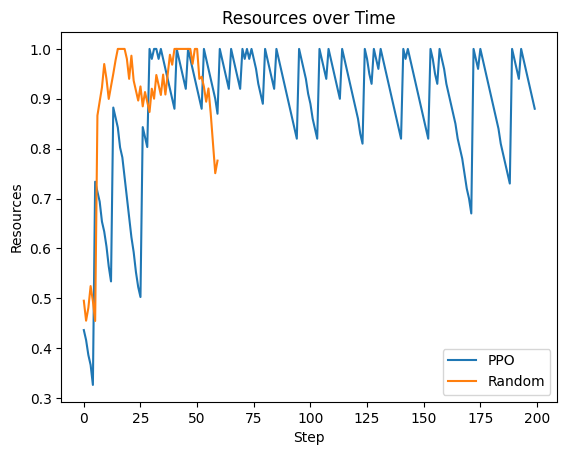

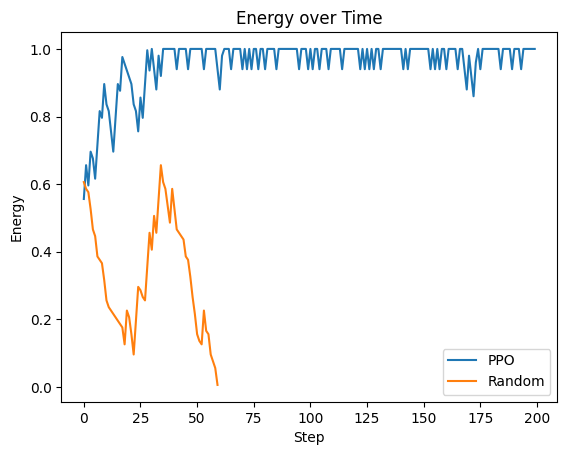

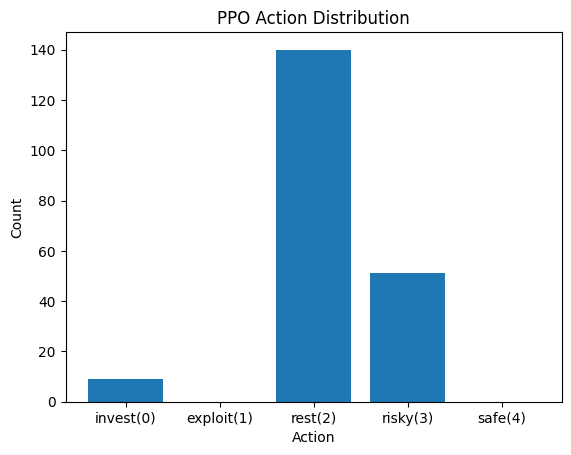

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [8]:
import matplotlib.pyplot as plt

def unpack_traj(traj):
    actions = [x[0] for x in traj]
    rewards = [x[1] for x in traj]
    skill = [x[2] for x in traj]
    energy = [x[3] for x in traj]
    resources = [x[4] for x in traj]
    confidence = [x[5] for x in traj]
    return actions, rewards, skill, energy, resources, confidence

ppo_actions, ppo_rewards, ppo_skill, ppo_energy, ppo_res, ppo_conf = unpack_traj(ppo_traj)
rnd_actions, rnd_rewards, rnd_skill, rnd_energy, rnd_res, rnd_conf = unpack_traj(rnd_traj)

# Plot 1: Resources over time (PPO vs Random)
plt.figure()
plt.plot(ppo_res, label="PPO")
plt.plot(rnd_res, label="Random")
plt.title("Resources over Time")
plt.xlabel("Step")
plt.ylabel("Resources")
plt.legend()
plt.show()

# Plot 2: Energy over time (PPO vs Random)
plt.figure()
plt.plot(ppo_energy, label="PPO")
plt.plot(rnd_energy, label="Random")
plt.title("Energy over Time")
plt.xlabel("Step")
plt.ylabel("Energy")
plt.legend()
plt.show()

# Plot 3: Action histogram (what PPO prefers)
plt.figure()
plt.hist(ppo_actions, bins=np.arange(-0.5, 5.5, 1), rwidth=0.8)
plt.xticks([0,1,2,3,4], ["invest(0)","exploit(1)","rest(2)","risky(3)","safe(4)"])
plt.title("PPO Action Distribution")
plt.xlabel("Action")
plt.ylabel("Count")
plt.show()


In [9]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

# Baseline env (no skill bonus)
vec_base = make_vec_env(lambda: LongHorizonDecisionEnv(max_steps=200, seed=271, skill_bonus_weight=0.0), n_envs=1)
model_base = PPO("MlpPolicy", vec_base, verbose=0)
model_base.learn(total_timesteps=10_000)

# Skill-bonus env (encourage investing)
vec_skill = make_vec_env(lambda: LongHorizonDecisionEnv(max_steps=200, seed=271, skill_bonus_weight=0.8), n_envs=1)
model_skill = PPO("MlpPolicy", vec_skill, verbose=0)
model_skill.learn(total_timesteps=10_000)

print("Both trainings finished.")


Both trainings finished.


Baseline total reward: 5.866 | steps: 15
Skill-bonus total reward: 179.677 | steps: 200


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


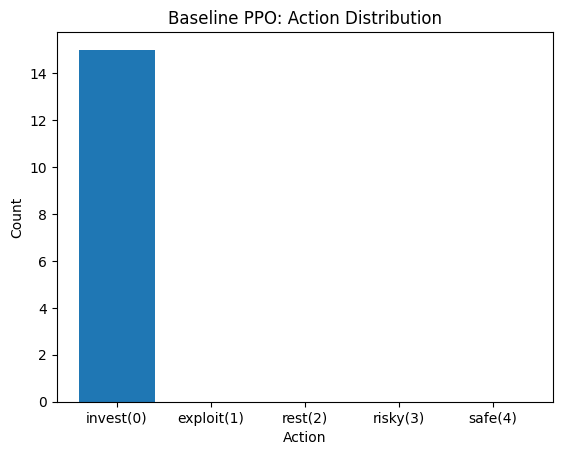

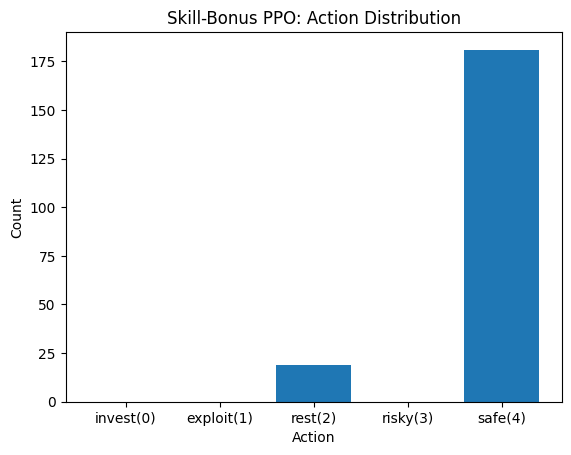

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [10]:
import numpy as np
import matplotlib.pyplot as plt

def run_episode_actions(env, policy, max_steps=200, seed=123, deterministic=True):
    obs, _ = env.reset(seed=seed)
    actions = []
    totals = 0.0

    for _ in range(max_steps):
        act, _ = policy.predict(obs, deterministic=deterministic)
        obs, reward, terminated, truncated, info = env.step(int(act))
        actions.append(int(act))
        totals += float(reward)
        if terminated or truncated:
            break

    return totals, actions

# Fresh envs for evaluation (same seed so it's comparable)
env_base_eval = LongHorizonDecisionEnv(max_steps=200, seed=999, skill_bonus_weight=0.0)
env_skill_eval = LongHorizonDecisionEnv(max_steps=200, seed=999, skill_bonus_weight=0.8)

base_total, base_actions = run_episode_actions(env_base_eval, model_base, seed=999)
skill_total, skill_actions = run_episode_actions(env_skill_eval, model_skill, seed=999)

print("Baseline total reward:", round(base_total, 3), "| steps:", len(base_actions))
print("Skill-bonus total reward:", round(skill_total, 3), "| steps:", len(skill_actions))

# Plot action histograms side-by-side
bins = np.arange(-0.5, 5.5, 1)

plt.figure()
plt.hist(base_actions, bins=bins, rwidth=0.8)
plt.xticks([0,1,2,3,4], ["invest(0)","exploit(1)","rest(2)","risky(3)","safe(4)"])
plt.title("Baseline PPO: Action Distribution")
plt.xlabel("Action")
plt.ylabel("Count")
plt.show()

plt.figure()
plt.hist(skill_actions, bins=bins, rwidth=0.8)
plt.xticks([0,1,2,3,4], ["invest(0)","exploit(1)","rest(2)","risky(3)","safe(4)"])
plt.title("Skill-Bonus PPO: Action Distribution")
plt.xlabel("Action")
plt.ylabel("Count")
plt.show()


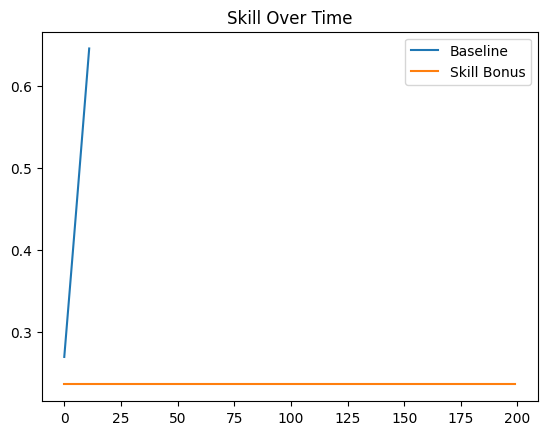

In [11]:
def run_episode_full(env, policy, max_steps=200, seed=123):
    obs, _ = env.reset(seed=seed)
    skill_list = []
    energy_list = []
    resource_list = []

    for _ in range(max_steps):
        act, _ = policy.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(int(act))
        skill_list.append(info["skill"])
        energy_list.append(info["energy"])
        resource_list.append(info["resources"])
        if terminated or truncated:
            break

    return skill_list, energy_list, resource_list

# Evaluate both
env_base_eval = LongHorizonDecisionEnv(max_steps=200, seed=999, skill_bonus_weight=0.0)
env_skill_eval = LongHorizonDecisionEnv(max_steps=200, seed=999, skill_bonus_weight=0.8)

skill_base, energy_base, res_base = run_episode_full(env_base_eval, model_base)
skill_skill, energy_skill, res_skill = run_episode_full(env_skill_eval, model_skill)

import matplotlib.pyplot as plt

plt.figure()
plt.plot(skill_base, label="Baseline")
plt.plot(skill_skill, label="Skill Bonus")
plt.title("Skill Over Time")
plt.legend()
plt.show()
